In [61]:
import tensorflow as tf
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
from foolbox import PyTorchModel, accuracy, samples
import torch
import eagerpy as ep



In [62]:
print("TensorFlow version: ", fb.__version__)

TensorFlow version:  3.3.4


In [63]:
# MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# normalizing
x_test = x_test.astype(np.float32) / 255.0
x_test = np.expand_dims(x_test, axis=-1) 

# getting a subset for experimenting, first 10 images
images = x_test[:15]  
labels = y_test[:15]  

print("images.shape: ", images.shape)
images = images.numpy() if hasattr(images, 'numpy') else images
labels = labels.numpy() if hasattr(labels, 'numpy') else labels

labels = labels.astype('int64')  # For numpy-based operations
# labels = torch.tensor(labels).long()  # For PyTorch tensors
print("images.shape: ", images.shape)
# images, labels = ep.astensors(images, labels)
images= tf.convert_to_tensor(images)
print("images.shape: ", images.shape)
# images = tf.image.rgb_to_grayscale(images)

images.shape:  (15, 28, 28, 1)
images.shape:  (15, 28, 28, 1)
images.shape:  (15, 28, 28, 1)


In [64]:
model = tf.keras.models.load_model('mnist_cnn_model.keras')

In [65]:
tf.config.run_functions_eagerly(True)

print("TensorFlow version:", tf.__version__)
print("Foolbox version:", fb.__version__)

TensorFlow version: 2.16.2
Foolbox version: 3.3.4


In [66]:
# wrapping the model with foolbox
fmodel = fb.TensorFlowModel(model, bounds=(0, 1), preprocessing=None)

def custom_loss_fn(logits, labels):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# Set the custom loss function for the Foolbox attacks
fmodel.loss_fn = custom_loss_fn


# instantiate a model (could also be a TensorFlow or JAX model)
# model = models.resnet18(pretrained=True).eval()
# preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
# fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)
# fmodel = PyTorchModel(model)

# trying all the norms
# l0_attack = fb.attacks.L0BrendelBethgeAttack()
l0_attack = fb.attacks.L0FMNAttack()
l1_attack = fb.attacks.L1FMNAttack()
l2_attack = fb.attacks.L2FMNAttack()
linf_attack = fb.attacks.LInfFMNAttack()

# set of epsilons (perturbation levels)
epsilons = [None]

In [67]:
# L0 attack
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
l0_raw_advs, l0_clipped_advs, l0_success = l0_attack(fmodel, images, labels, epsilons=[None])

# L1 attack
l1_raw_advs, l1_clipped_advs, l1_success = l1_attack(fmodel, images, labels, epsilons=epsilons)

# L2 attack
l2_raw_advs, l2_clipped_advs, l2_success = l2_attack(fmodel, images, labels, epsilons=[None])

# Linf attack
linf_raw_advs, linf_clipped_advs, linf_success = linf_attack(fmodel, images, labels, epsilons=epsilons)

# shows which images where successfully attacked
print("L0 attack success:", l0_success)
print("L1 attack success:", l1_success)
print("L2 attack success:", l2_success)
print("Linf attack success:", linf_success)

Images shape: (15, 28, 28, 1)
Labels shape: (15,)
Do changes get noticed in execution?
Do changes get noticed in execution?
Do changes get noticed in execution?
Do changes get noticed in execution?
L0 attack success: tf.Tensor(
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]], shape=(1, 15), dtype=bool)
L1 attack success: tf.Tensor(
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]], shape=(1, 15), dtype=bool)
L2 attack success: tf.Tensor(
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True]], shape=(1, 15), dtype=bool)
Linf attack success: tf.Tensor(
[[False False False False False False False False False False False False
  False False False]], shape=(1, 15), dtype=bool)


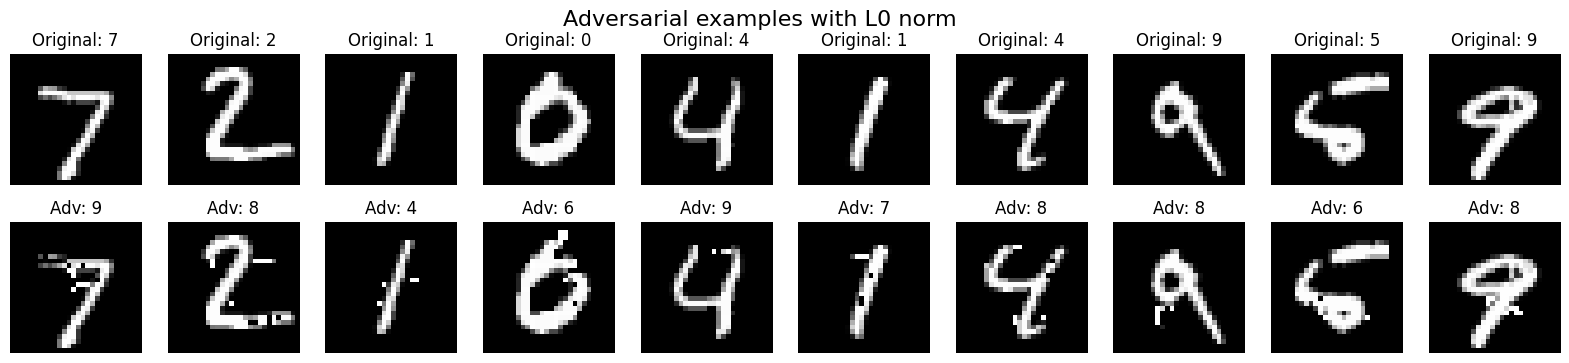

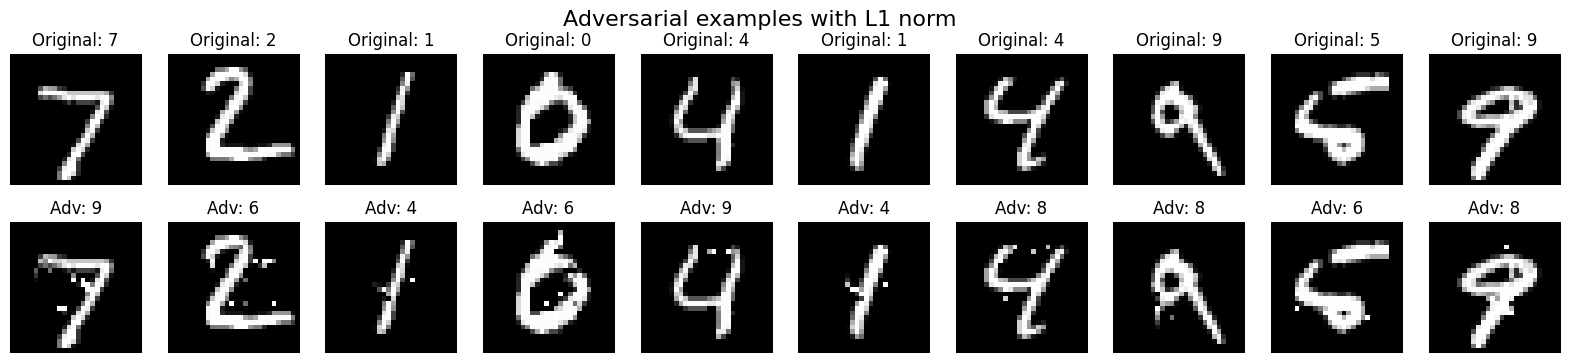

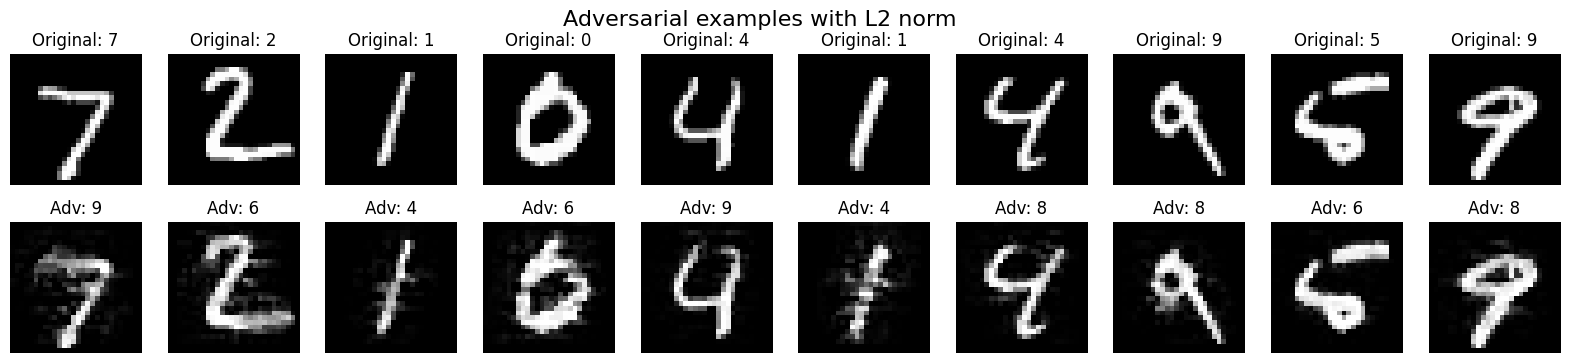

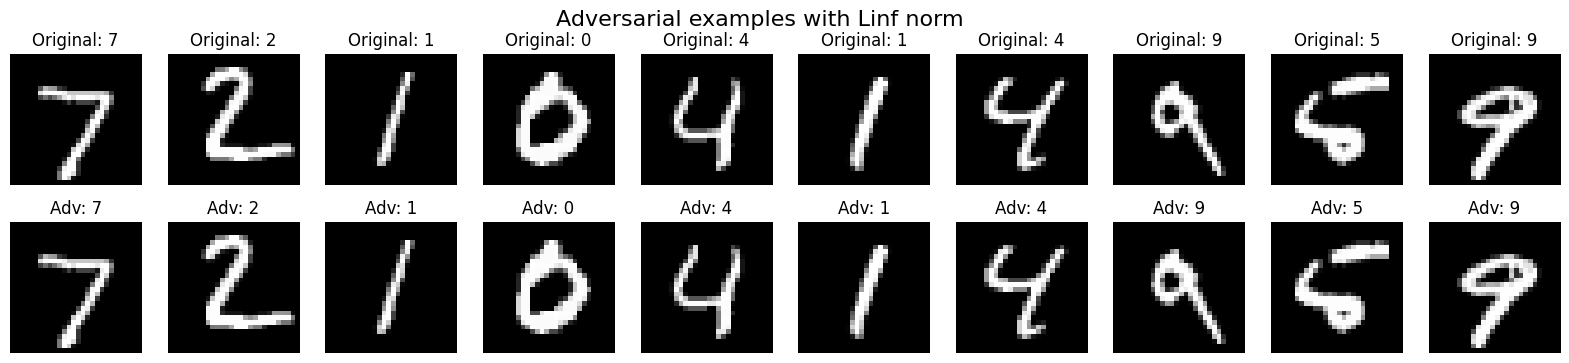

In [74]:
def plot_comparison(images, adv_images, adv_labels, norm_name):
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        # original image
        axes[0, i].imshow(images[i], cmap="gray")
        axes[0, i].set_title(f"Original: {labels[i]}")
        axes[0, i].axis('off')

        # adversarial image
        axes[1, i].imshow(adv_images[i], cmap="gray")
        axes[1, i].set_title(f"Adv: {adv_labels[i]}")
        axes[1, i].axis('off')

    plt.suptitle(f"Adversarial examples with {norm_name} norm", fontsize=16)
    plt.show()

# everywhere for epsilon = 0.2
# L0 attack results
l0_adv_labels = np.argmax(fmodel(l0_clipped_advs[0]), axis=-1)  
plot_comparison(images, l0_clipped_advs[0], l0_adv_labels, "L0")

# L1 attack results
l1_adv_labels = np.argmax(fmodel(l1_clipped_advs[0]), axis=-1)  
plot_comparison(images, l1_clipped_advs[0], l1_adv_labels, "L1")

# L2 attack results
l2_adv_labels = np.argmax(fmodel(l2_clipped_advs[0]), axis=-1)  
plot_comparison(images, l2_clipped_advs[0], l2_adv_labels, "L2")

# Linf attack results
linf_adv_labels = np.argmax(fmodel(linf_clipped_advs[0]), axis=-1) 
plot_comparison(images, linf_clipped_advs[0], linf_adv_labels, "Linf")


In [75]:
# success rate for each attack
l0_success_rate = np.mean(l0_success)
l1_success_rate = np.mean(l1_success)
l2_success_rate = np.mean(l2_success)
linf_success_rate = np.mean(linf_success)

print(f"L0 Success Rate: {l0_success_rate * 100:.2f}%")
print(f"L1 Success Rate: {l1_success_rate * 100:.2f}%")
print(f"L2 Success Rate: {l2_success_rate * 100:.2f}%")
print(f"Linf Success Rate: {linf_success_rate * 100:.2f}%")

L0 Success Rate: 100.00%
L1 Success Rate: 100.00%
L2 Success Rate: 100.00%
Linf Success Rate: 0.00%
